# FPL Points Predictor Modeling II

### Package Installments

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set(style = "ticks")
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import regression
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import cross_val_score
from sklearn.learning_curve import validation_curve
from sklearn.cross_validation import train_test_split

/accre/arch/easybuild/software/BinDist/Anaconda3/5.0.1/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/accre/arch/easybuild/software/BinDist/Anaconda3/5.0.1/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


### Useful functions

In [3]:
## This function is used to select the best degree for polynomial regression
def best_degree(model, df_x,df_y):
    degree = np.arange(10)
    train_score, val_score = validation_curve(model, df_x, df_y, 'polynomialfeatures__degree', degree, cv = 5)
    degree = pd.Series(degree)
    train = pd.Series(np.median(train_score,1))
    val = pd.Series(np.median(val_score,1))
    record = pd.DataFrame({'degree': degree, 'train_score': train, 'val_score': val})
    record_max = record.loc[record[['val_score']].idxmax(), 'degree']
    record_max2 = record_max.reset_index(drop = True)
    return record_max2[0]

In [4]:
## This function is used to see how the training curve and validation curve vary for different degrees
def val_curve(model, df_x, df_y):
    degree = np.arange(1,6)
    train_score, val_score = validation_curve(model, df_x, df_y, 'polynomialfeatures__degree', degree, cv = 5)
    best = best_degree(model,df_x,df_y)
    deg = np.linspace(1,5,200)
    smooth_train = make_interp_spline(degree, np.median(train_score,1))
    smooth_val = make_interp_spline(degree, np.median(val_score, 1))
    
    plt.plot(deg, smooth_train(deg), color = 'blue', label = 'training curve')
    plt.plot(deg, smooth_val(deg), color = 'red', label = 'validation curve')
    plt.scatter(best, np.max(np.median(val_score,1)), marker = 'x', color = 'black', label = 'max')
    plt.legend(loc = 'best')
    plt.xlabel('Degree')
    plt.ylabel('Accuracy score')
    plt.ylim(0,1);

In [5]:
## This function is used split data into training and testing sets
def split_data(df_new, rand_state = 69):
    df_x = df_new[['player_name','ict_index','bps', 'position_index','minutes', 'bonus']]
    df_y = df_new['total_points']
    df_xm = df_new[['ict_index','bps']]
    df_xtrain, df_xtest, df_ytrain, df_ytest = train_test_split(df_x, df_y, random_state = rand_state, train_size = 0.8)
    df_xtrain_new = df_xtrain[['ict_index','bps']]
    df_xtest_new = df_xtest[['ict_index','bps']]
    return (df_x, df_y, df_xm, df_xtrain, df_xtest, df_ytrain, df_ytest, df_xtrain_new, df_xtest_new)

In [6]:
## This function is used to generate a new table with the fpl predictions
def new_output(df_xtest,df_ytest, df_pred):
    df_m = df_xtest.copy()
    df_m['total_points'] = df_ytest
    df_m['fpl_to_game'] = (df_m['total_points']/df_m['minutes'])*90
    df_m['pred_points'] = df_pred
    df_m['fpl_to_game pred'] = (df_m['pred_points']/df_m['minutes'])*90
    df_m2 = df_m.reset_index()
    df_m2 = df_m2.drop('index', axis = 1)
    return df_m2.head()

### Creating the basic  model

In [7]:
model = make_pipeline(PolynomialFeatures(), LinearRegression())

## Premier League 2016/17

In [8]:
s17 = pd.read_csv("~/DSI-SRP1/FPL_2016_17_new.csv", encoding = "latin1")

In [9]:
s17.shape

(15348, 17)

In [10]:
s17 = s17.drop("Unnamed: 0", axis = 1)

In [11]:
s17.corr()

position_index  goals_scored   assists  ict_index  \
position_index        1.000000      0.358863  0.245121   0.184788   
goals_scored          0.358863      1.000000  0.547061   0.780824   
assists               0.245121      0.547061  1.000000   0.766502   
ict_index             0.184788      0.780824  0.766502   1.000000   
goals_conceded       -0.160156      0.358126  0.366150   0.661806   
minutes              -0.175043      0.426919  0.467052   0.779357   
own_goals            -0.162512     -0.007061 -0.039619   0.060669   
total_points          0.005081      0.701439  0.667583   0.904662   
bps                  -0.201076      0.491085  0.523756   0.807495   
bonus                 0.087055      0.749327  0.618507   0.816114   
clean_sheets         -0.096940      0.424499  0.472034   0.723500   
GW                   -0.023873      0.257770  0.279690   0.453184   

                goals_conceded   minutes  own_goals  total_points       bps  \
position_index       -0.160156 -0.175043  -0.162512      0.005081 -0.201076   
goals_scored          0.358126  0.426919  -0.007061      0.701439  0.491085   
assists               0.366150  0.467052  -0.039619      0.667583  0.523756   
ict_index             0.661806  0.779357   0.060669      0.904662  0.807495   
goals_conceded        1.000000  0.899777   0.232797      0.717972  0.807627   
minutes               0.899777  1.000000   0.187911      0.882344  0.951450   
own_goals             0.232797  0.187911   1.000000      0.093695  0.167557   
total_points          0.717972  0.882344   0.093695      1.000000  0.931196   
bps                   0.807627  0.951450   0.167557      0.931196  1.000000   
bonus                 0.505286  0.638545   0.047431      0.850339  0.764499   
clean_sheets          0.580389  0.840792   0.083215      0.856388  0.865786   
GW                    0.530830  0.560771   0.107552      0.507641  0.538806   

                   bonus  clean_sheets        GW  
position_index  0.087055     -0.096940 -0.023873  
goals_scored    0.749327      0.424499  0.257770  
assists         0.618507      0.472034  0.279690  
ict_index       0.816114      0.723500  0.453184  
goals_conceded  0.505286      0.580389  0.530830  
minutes         0.638545      0.840792  0.560771  
own_goals       0.047431      0.083215  0.107552  
total_points    0.850339      0.856388  0.507641  
bps             0.764499      0.865786  0.538806  
bonus           1.000000      0.638605  0.350143  
clean_sheets    0.638605      1.000000  0.478279  
GW              0.350143      0.478279  1.000000

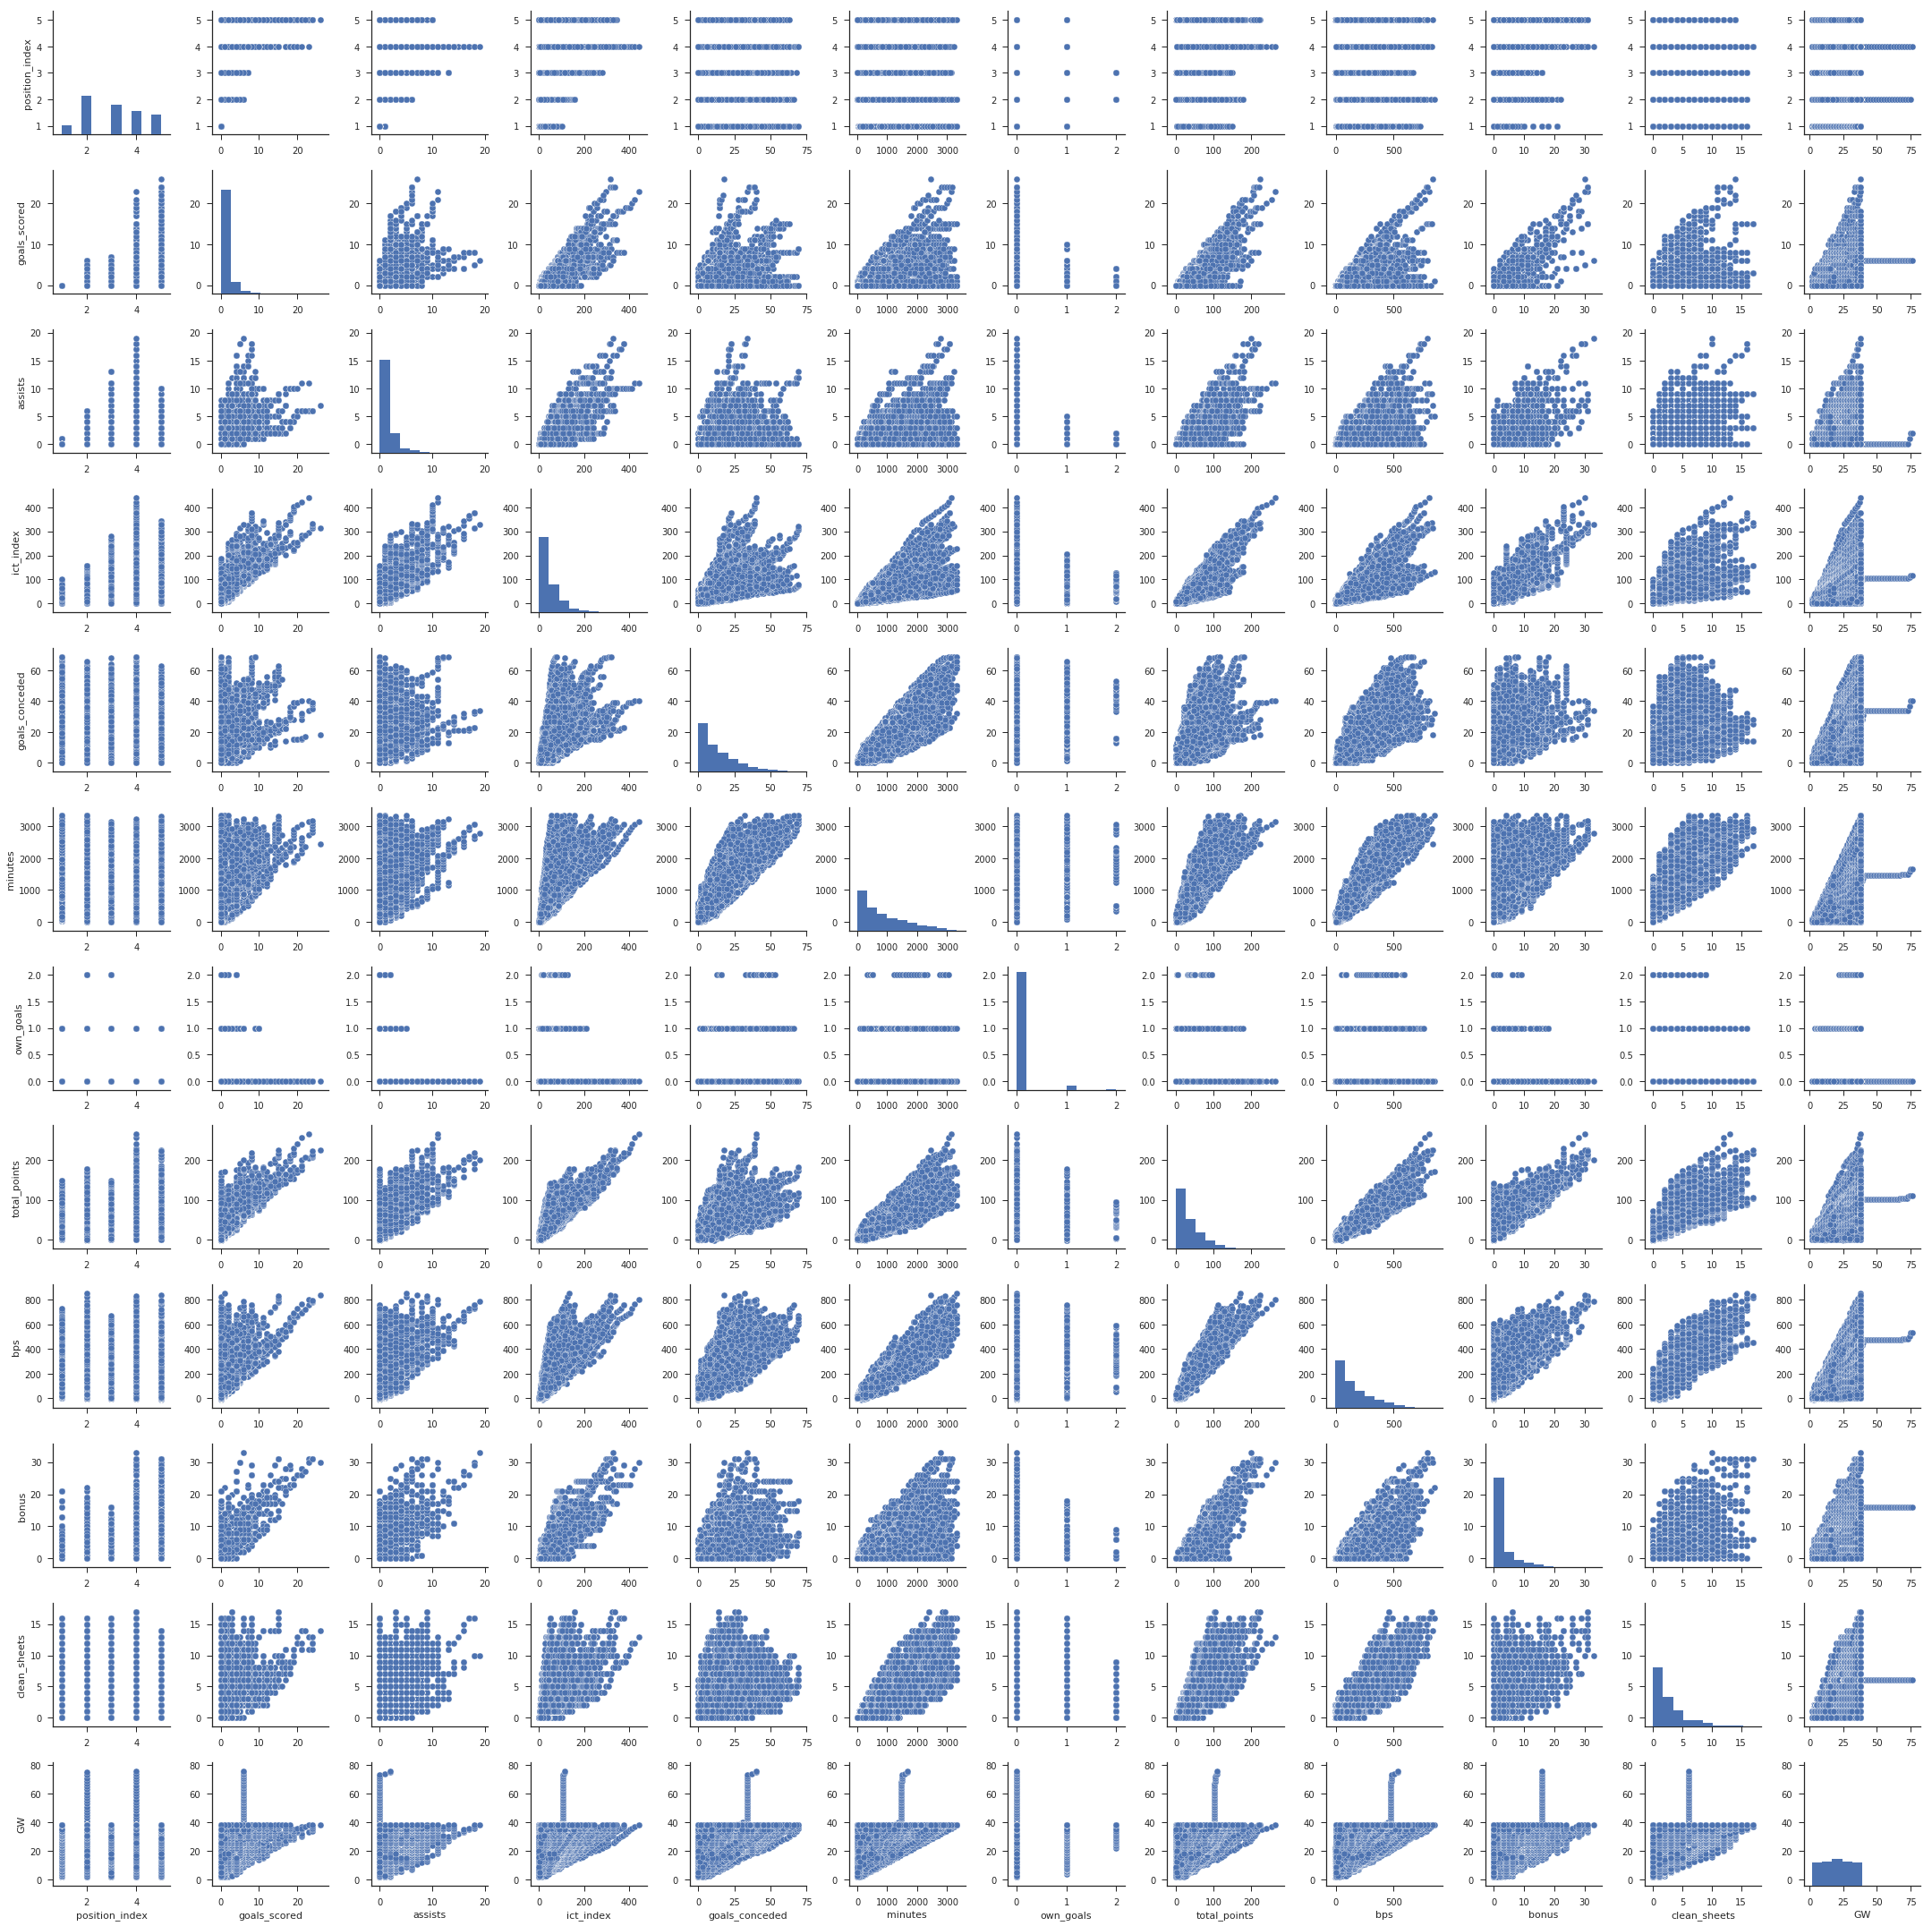

In [12]:
sns.pairplot(s17);

In [13]:
s17.columns

Index(['player_name', 'club_name', 'position', 'position_index',
       'goals_scored', 'assists', 'ict_index', 'goals_conceded', 'minutes',
       'own_goals', 'total_points', 'bps', 'bonus', 'clean_sheets', 'GW',
       'season'],
      dtype='object')

In [14]:
s17['fpl_to_game'] = (s17['total_points']/s17['minutes'])*90

In [15]:
s17_x, s17_y, s17_xm, s17_xtrain, s17_xtest, s17_ytrain, s17_ytest, s17_xtrain_new, s17_xtest_new = split_data(s17)

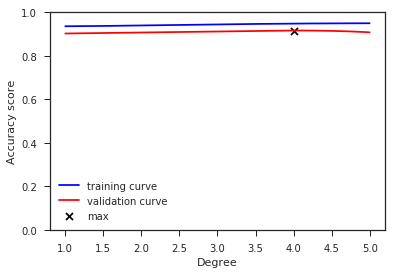

In [16]:
val_curve(model, s17_xm, s17_y)

In [17]:
model17 = make_pipeline(PolynomialFeatures(best_degree(model, s17_xm, s17_y)), LinearRegression())

In [18]:
s17_pred = model17.fit(s17_xtrain_new, s17_ytrain).predict(s17_xtest_new)

In [19]:
r2_score(s17_pred, s17_ytest)

0.94695647067661148

In [20]:
score17 = cross_val_score(model17, s17_xm, s17_y, cv = 5)
score17

array([ 0.83659493,  0.89437014,  0.91651979,  0.9356822 ,  0.94196654])

In [21]:
score17.mean()

0.90502671883140662

In [22]:
new_output(s17_xtest, s17_ytest, s17_pred)

player_name  ict_index  bps  position_index  minutes  bonus  \
0  Fernando Luiz Rosa      101.3  343               3     2035      3   
1        Yohan Cabaye       43.7   75               3      368      3   
2       Phil Bardsley       35.4  174               2     1168      0   
3   Toby Alderweireld       41.8  249               2     1049      0   
4       Cesc Fàbregas       88.7  302               3      738      8   

   total_points  fpl_to_game  pred_points  fpl_to_game pred  
0            55     2.432432    71.618187          3.167389  
1            15     3.668478    25.912410          6.337274  
2            27     2.080479    32.882133          2.533726  
3            53     4.547188    44.387649          3.808283  
4            71     8.658537    63.080215          7.692709

## Premier League 2017/18

In [23]:
s18 = pd.read_csv("~/DSI-SRP1/FPL_2017_18_new.csv", encoding = "latin1")

In [24]:
s18.head()

Unnamed: 0         player_name          club_name          position  \
0           1     Aaron Cresswell    West Ham United         Left-Back   
1           2          Aaron Mooy  Huddersfield Town  Central Midfield   
2           3        Aaron Ramsey         Arsenal FC  Central Midfield   
3           4  Abdoulaye Doucouré         Watford FC  Central Midfield   
4           5          Adam Smith    AFC Bournemouth        Right-Back   

   position_index  goals_scored  assists  ict_index  goals_conceded  minutes  \
0               2             0        0        1.9               2        9   
1               3             0        1        8.7               0       90   
2               3             1        0        6.7               0       23   
3               3             1        0       10.9               3       90   
4               2             0        0        0.3               0       10   

   own_goals  total_points  bps  bonus  clean_sheets  GW     season  
0          0             1    3      0             0   2  2017/2018  
1          0            16   22      0             1   2  2017/2018  
2          0             8   16      0             0   2  2017/2018  
3          0            12   36      2             0   2  2017/2018  
4          0             2    2      0             0   2  2017/2018

In [25]:
s18 = s18.drop("Unnamed: 0", axis = 1)

In [26]:
s18.columns

Index(['player_name', 'club_name', 'position', 'position_index',
       'goals_scored', 'assists', 'ict_index', 'goals_conceded', 'minutes',
       'own_goals', 'total_points', 'bps', 'bonus', 'clean_sheets', 'GW',
       'season'],
      dtype='object')

In [27]:
s18.corr()

position_index  goals_scored   assists  ict_index  \
position_index        1.000000      0.395129  0.257205   0.217481   
goals_scored          0.395129      1.000000  0.548606   0.773468   
assists               0.257205      0.548606  1.000000   0.783295   
ict_index             0.217481      0.773468  0.783295   1.000000   
goals_conceded       -0.139668      0.248762  0.343284   0.619976   
minutes              -0.145649      0.366509  0.467297   0.765583   
own_goals            -0.096463     -0.020822  0.001352   0.075760   
total_points          0.023026      0.671887  0.670718   0.902167   
bps                  -0.174128      0.473485  0.543183   0.810719   
bonus                 0.098433      0.730921  0.605659   0.791032   
clean_sheets         -0.083677      0.433917  0.506769   0.741789   
GW                   -0.021805      0.237770  0.282152   0.464028   

                goals_conceded   minutes  own_goals  total_points       bps  \
position_index       -0.139668 -0.145649  -0.096463      0.023026 -0.174128   
goals_scored          0.248762  0.366509  -0.020822      0.671887  0.473485   
assists               0.343284  0.467297   0.001352      0.670718  0.543183   
ict_index             0.619976  0.765583   0.075760      0.902167  0.810719   
goals_conceded        1.000000  0.900548   0.160021      0.687741  0.786497   
minutes               0.900548  1.000000   0.187102      0.873146  0.942791   
own_goals             0.160021  0.187102   1.000000      0.124942  0.183858   
total_points          0.687741  0.873146   0.124942      1.000000  0.938747   
bps                   0.786497  0.942791   0.183858      0.938747  1.000000   
bonus                 0.470768  0.624082   0.105927      0.847832  0.763483   
clean_sheets          0.548326  0.827795   0.141950      0.865874  0.870223   
GW                    0.557836  0.583030   0.092739      0.503715  0.536481   

                   bonus  clean_sheets        GW  
position_index  0.098433     -0.083677 -0.021805  
goals_scored    0.730921      0.433917  0.237770  
assists         0.605659      0.506769  0.282152  
ict_index       0.791032      0.741789  0.464028  
goals_conceded  0.470768      0.548326  0.557836  
minutes         0.624082      0.827795  0.583030  
own_goals       0.105927      0.141950  0.092739  
total_points    0.847832      0.865874  0.503715  
bps             0.763483      0.870223  0.536481  
bonus           1.000000      0.651517  0.329576  
clean_sheets    0.651517      1.000000  0.445266  
GW              0.329576      0.445266  1.000000

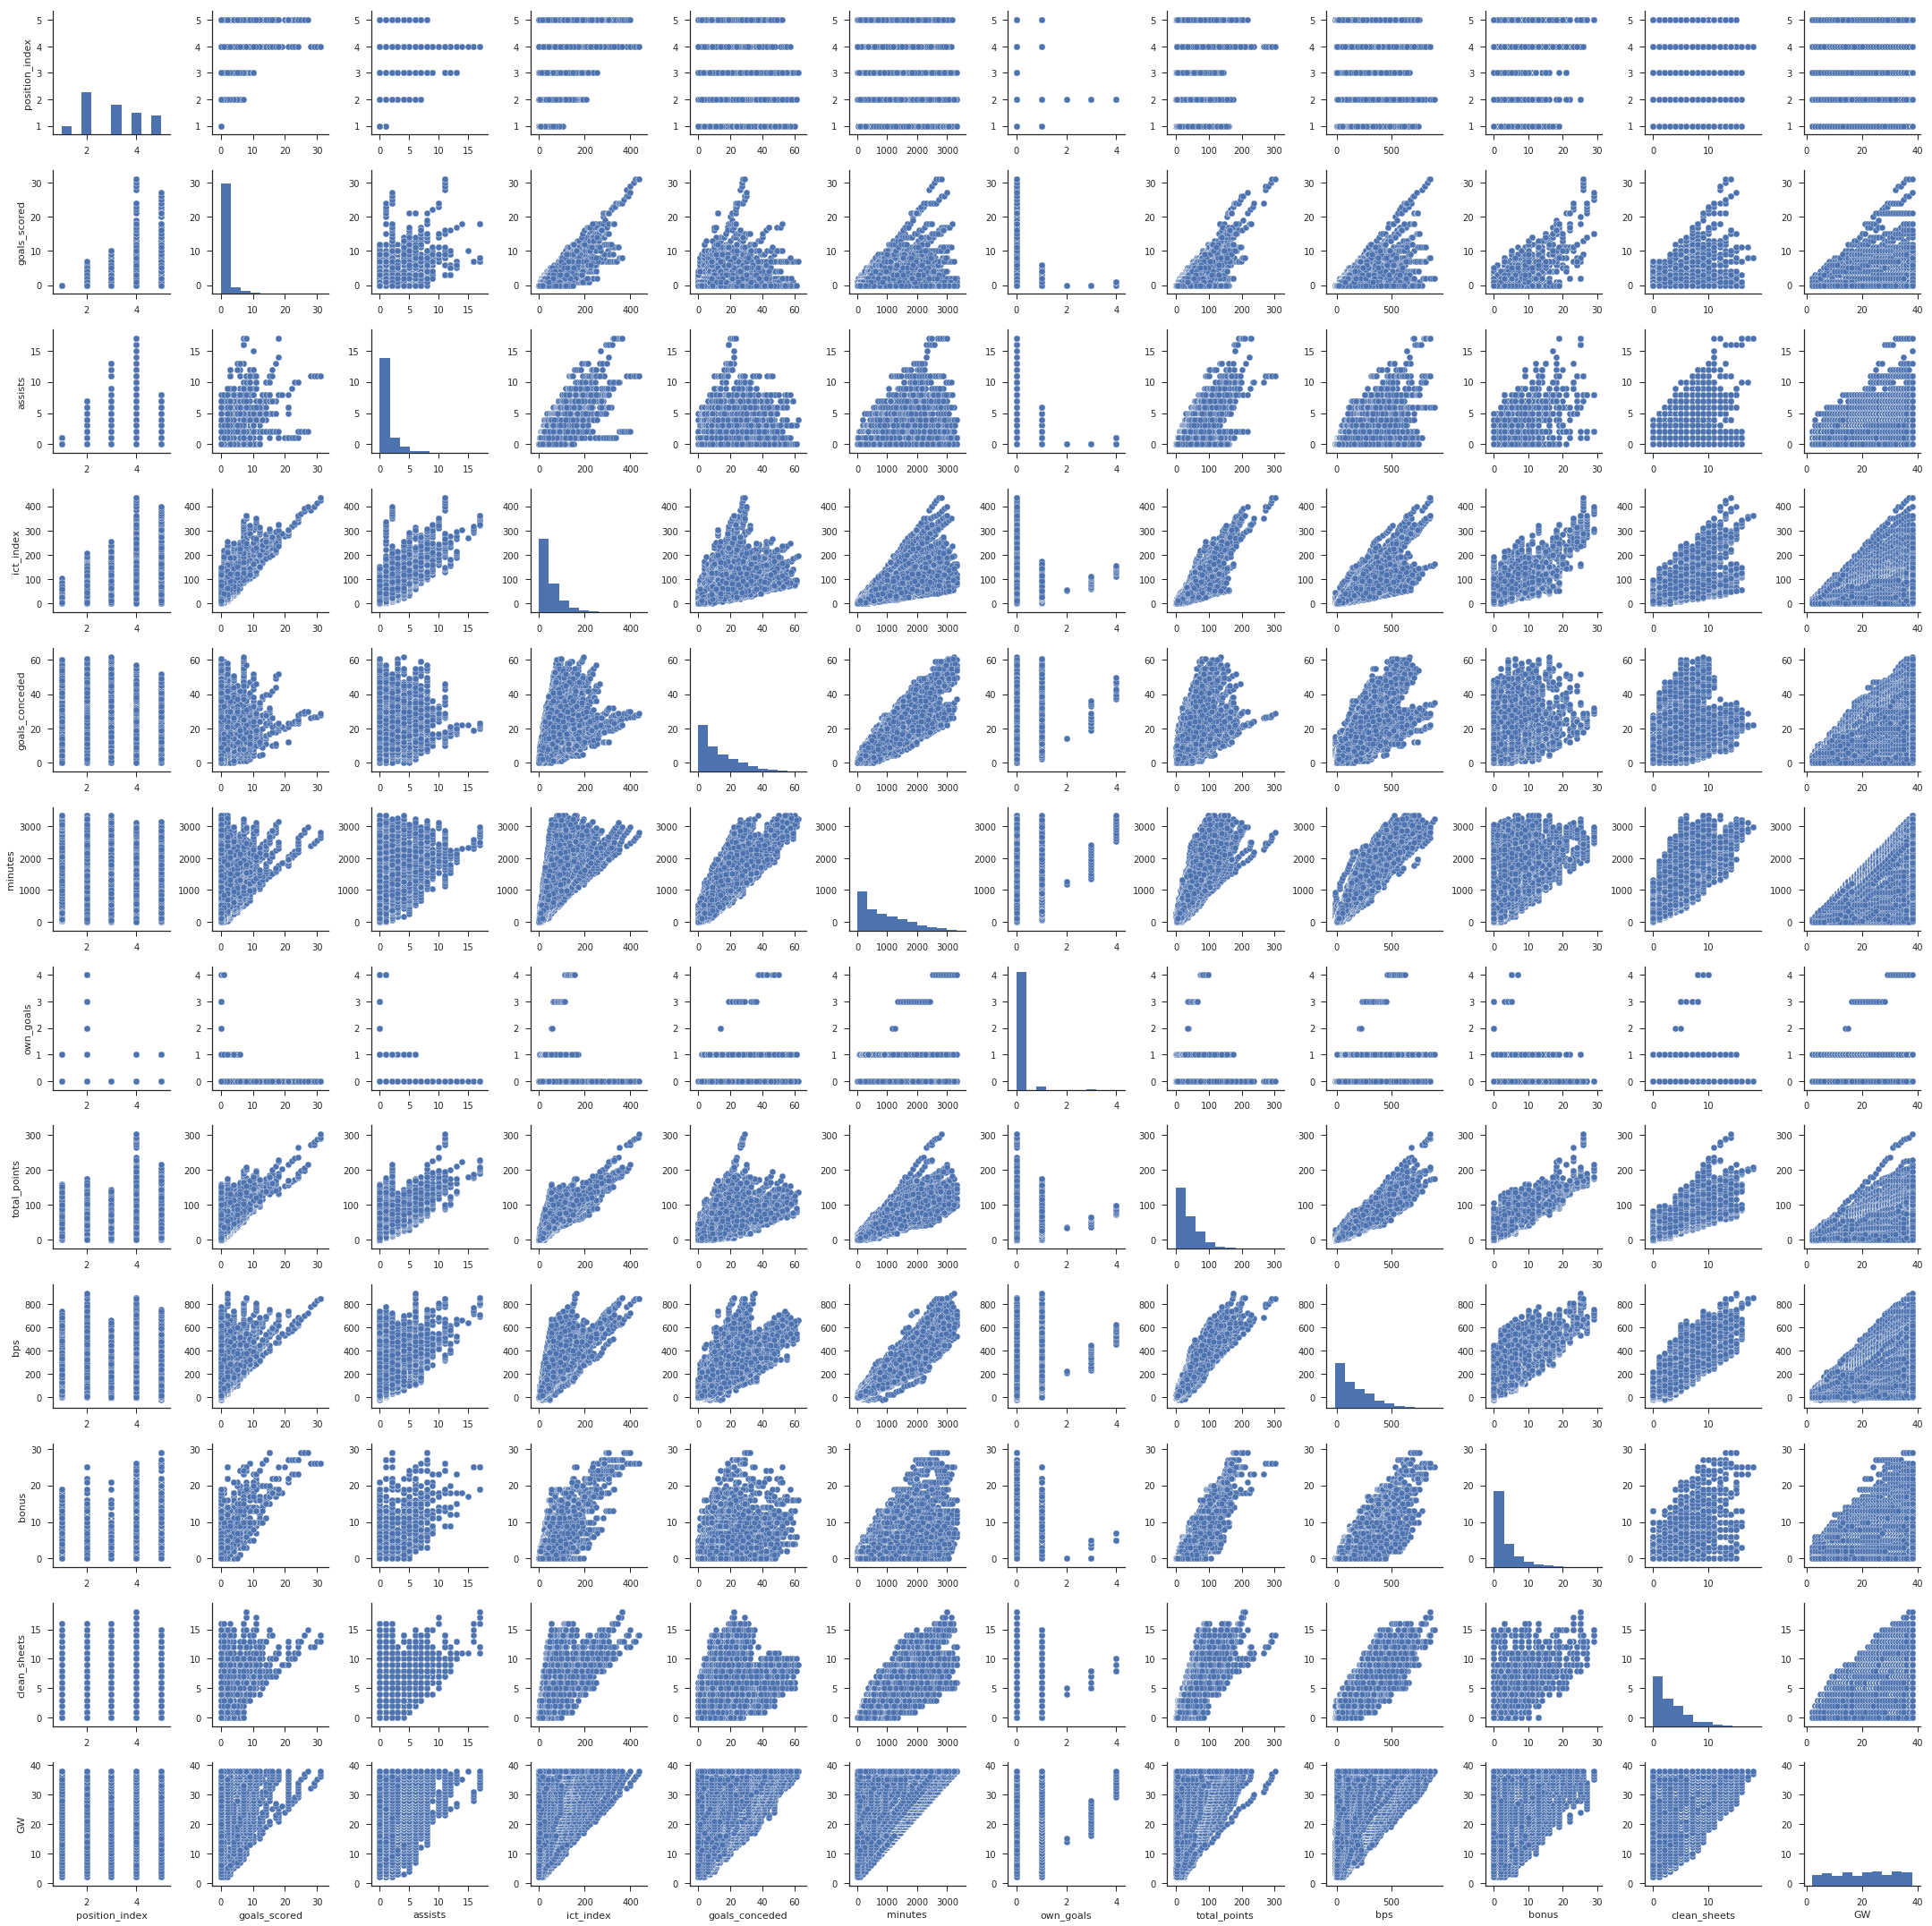

In [28]:
sns.pairplot(s18);

In [29]:
s18['fpl_to_game'] = (s18['total_points']/s18['minutes'])*90

In [30]:
s18_x, s18_y, s18_xm, s18_xtrain, s18_xtest, s18_ytrain, s18_ytest, s18_xtrain_new, s18_xtest_new = split_data(s18)

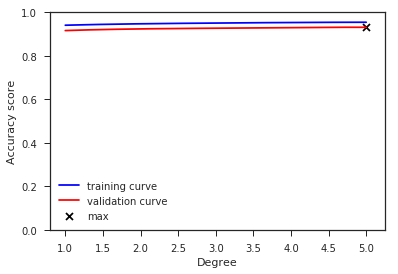

In [31]:
val_curve(model, s18_xm, s18_y)

In [32]:
model18 = make_pipeline(PolynomialFeatures(best_degree(model, s18_xm, s18_y)), LinearRegression())

In [33]:
s18_pred = model18.fit(s18_xtrain_new, s18_ytrain).predict(s18_xtest_new)

In [34]:
r2_score(s18_pred, s18_ytest)

0.95240542492601843

In [35]:
score18 = cross_val_score(model18, s18_xm, s18_y, cv = 5)
score18

array([ 0.84003172,  0.90707924,  0.9313656 ,  0.94678469,  0.94200922])

In [36]:
score18.mean()

0.91345409555202939

In [37]:
new_output(s18_xtest, s18_ytest, s18_pred)

player_name  ict_index  bps  position_index  minutes  bonus  \
0     Danny Ings        4.3    9               5       28      0   
1     Adam Smith       94.5  376               2     2067      3   
2  Harry Maguire       53.4  263               2     1170      4   
3    Ayoze Pérez       88.8  165               5     1436      5   
4   Victor Moses      121.1  476               4     2019      9   

   total_points  fpl_to_game  pred_points  fpl_to_game pred  
0             3     9.642857     3.784826         12.165513  
1            56     2.438316    73.697922          3.208908  
2            51     3.923077    48.877775          3.759829  
3            60     3.760446    56.154720          3.519446  
4           131     5.839525    95.551034          4.259333

## Premier League 2018/19

In [38]:
s19 = pd.read_csv("~/DSI-SRP1/FPL_2018_19_new.csv", encoding = "latin1")

In [39]:
s19.head()

Unnamed: 0         player_name          club_name          position  \
0           1        Aaron Lennon         Burnley FC      Right Winger   
1           2          Aaron Mooy  Huddersfield Town  Central Midfield   
2           3        Aaron Ramsey         Arsenal FC  Central Midfield   
3           4   Aaron Wan-Bissaka     Crystal Palace        Right-Back   
4           5  Abdoulaye Doucouré         Watford FC  Central Midfield   

   position_index  goals_scored  assists  ict_index  goals_conceded  minutes  \
0               4             0        0        3.9               0       90   
1               3             0        0        3.8               3       90   
2               3             0        0        2.9               1       53   
3               2             0        1        6.0               0       90   
4               3             0        0        3.9               0       90   

   own_goals  total_points  bps  bonus  clean_sheets  GW     season  
0          0             5    6      0             1   2  2018/2019  
1          0             2   24      0             0   2  2018/2019  
2          0             2    7      0             0   2  2018/2019  
3          0            10   38      3             1   2  2018/2019  
4          0             9   16      0             1   2  2018/2019

In [40]:
s19 = s19.drop("Unnamed: 0", axis = 1)

In [41]:
s19.columns

Index(['player_name', 'club_name', 'position', 'position_index',
       'goals_scored', 'assists', 'ict_index', 'goals_conceded', 'minutes',
       'own_goals', 'total_points', 'bps', 'bonus', 'clean_sheets', 'GW',
       'season'],
      dtype='object')

In [42]:
s19.corr()

position_index  goals_scored   assists  ict_index  \
position_index        1.000000      0.408487  0.271518   0.237270   
goals_scored          0.408487      1.000000  0.614028   0.815917   
assists               0.271518      0.614028  1.000000   0.756634   
ict_index             0.237270      0.815917  0.756634   1.000000   
goals_conceded       -0.143305      0.296671  0.286298   0.614709   
minutes              -0.141546      0.419947  0.431569   0.766177   
own_goals            -0.122405     -0.016246  0.035322   0.082813   
total_points          0.054031      0.707379  0.679285   0.904410   
bps                  -0.164944      0.501882  0.532588   0.803373   
bonus                 0.099135      0.749812  0.643920   0.801714   
clean_sheets         -0.070588      0.435305  0.477760   0.713670   
GW                   -0.039230      0.247538  0.275782   0.470157   

                goals_conceded   minutes  own_goals  total_points       bps  \
position_index       -0.143305 -0.141546  -0.122405      0.054031 -0.164944   
goals_scored          0.296671  0.419947  -0.016246      0.707379  0.501882   
assists               0.286298  0.431569   0.035322      0.679285  0.532588   
ict_index             0.614709  0.766177   0.082813      0.904410  0.803373   
goals_conceded        1.000000  0.887632   0.217080      0.649297  0.757021   
minutes               0.887632  1.000000   0.202550      0.864674  0.941168   
own_goals             0.217080  0.202550   1.000000      0.090223  0.172086   
total_points          0.649297  0.864674   0.090223      1.000000  0.930807   
bps                   0.757021  0.941168   0.172086      0.930807  1.000000   
bonus                 0.446644  0.635058   0.065411      0.862229  0.771575   
clean_sheets          0.510597  0.814124   0.084177      0.853781  0.852712   
GW                    0.551074  0.595898   0.100830      0.505221  0.544471   

                   bonus  clean_sheets        GW  
position_index  0.099135     -0.070588 -0.039230  
goals_scored    0.749812      0.435305  0.247538  
assists         0.643920      0.477760  0.275782  
ict_index       0.801714      0.713670  0.470157  
goals_conceded  0.446644      0.510597  0.551074  
minutes         0.635058      0.814124  0.595898  
own_goals       0.065411      0.084177  0.100830  
total_points    0.862229      0.853781  0.505221  
bps             0.771575      0.852712  0.544471  
bonus           1.000000      0.644773  0.337431  
clean_sheets    0.644773      1.000000  0.452788  
GW              0.337431      0.452788  1.000000

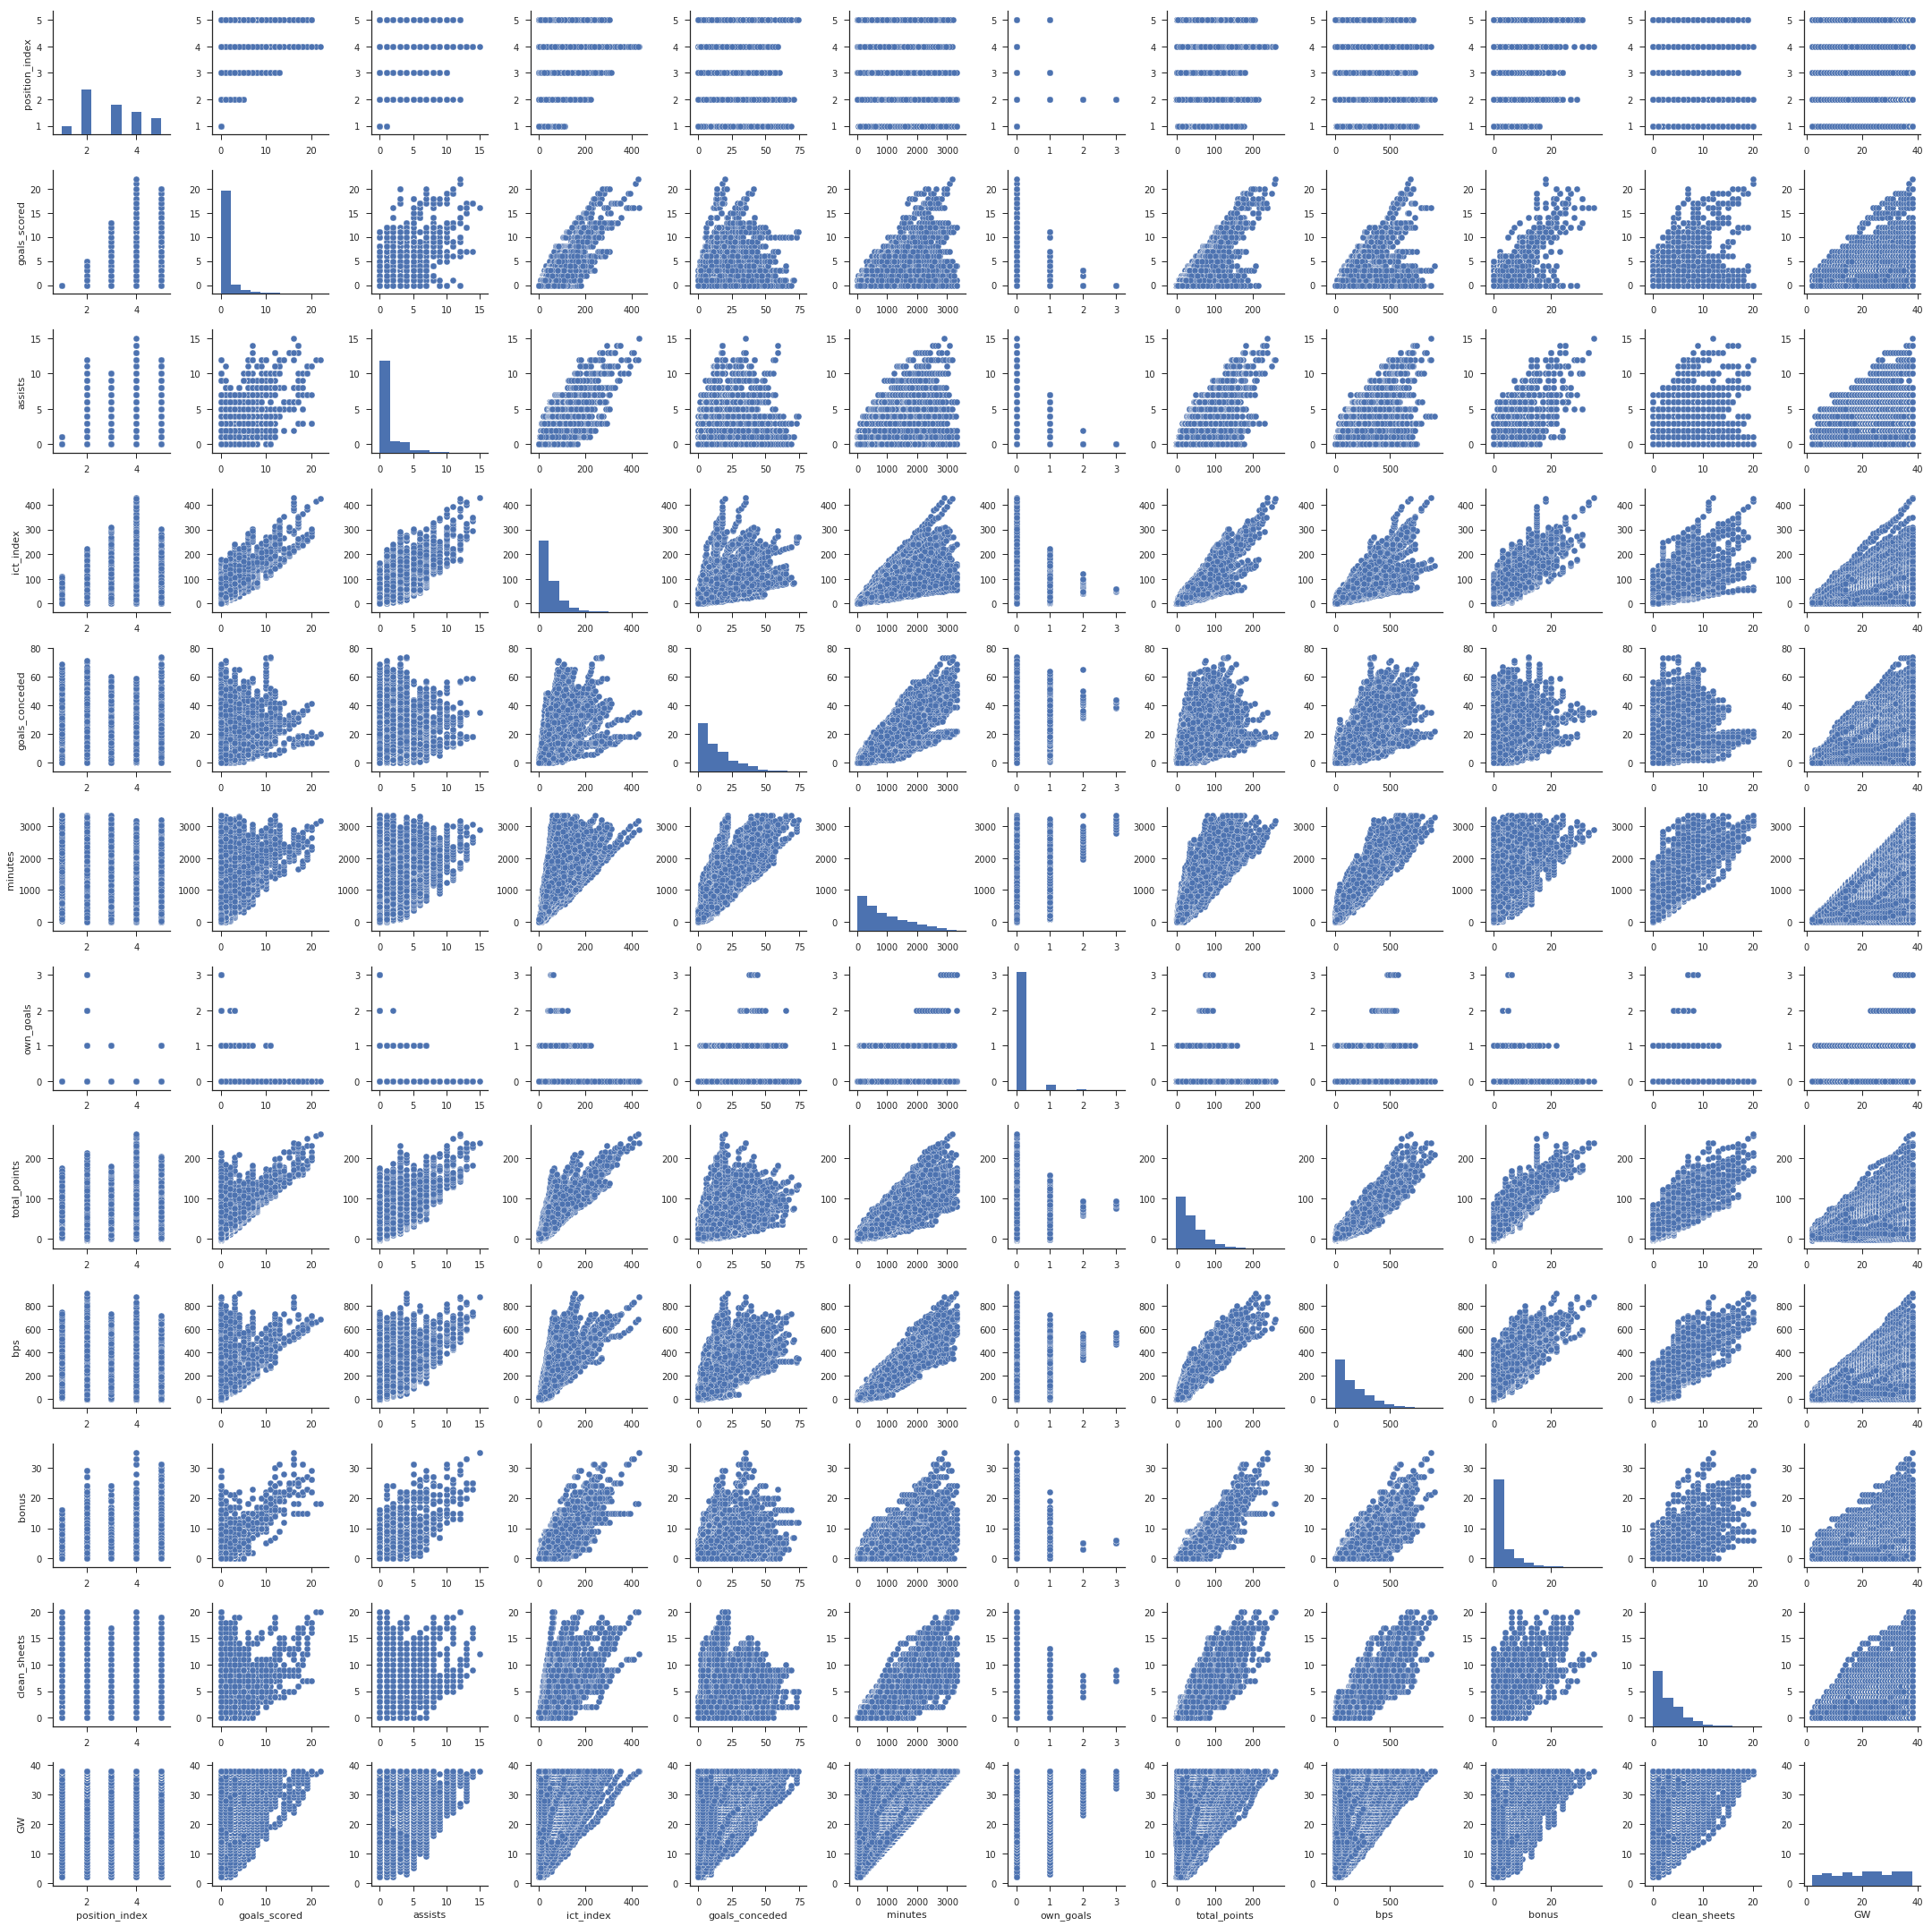

In [43]:
sns.pairplot(s19);

In [44]:
s19['fpl_to_game'] = (s19['total_points']/s19['minutes'])*90

In [45]:
s19_x, s19_y, s19_xm, s19_xtrain, s19_xtest, s19_ytrain, s19_ytest, s19_xtrain_new, s19_xtest_new = split_data(s19)

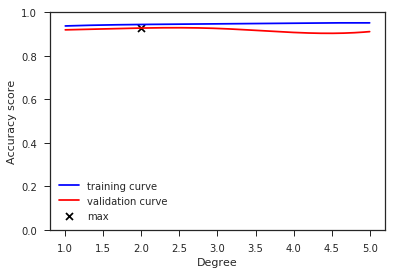

In [46]:
val_curve(model, s19_xm, s19_y)

In [47]:
model19 = make_pipeline(PolynomialFeatures(best_degree(model, s19_xm, s19_y)), LinearRegression())

In [48]:
s19_pred = model19.fit(s19_xtrain_new, s19_ytrain).predict(s19_xtest_new)

In [49]:
r2_score(s19_pred, s19_ytest)

0.93933729085365292

In [50]:
score19 = cross_val_score(model19, s19_xm, s19_y, cv = 5)
score19

array([ 0.82073345,  0.88507608,  0.92781232,  0.93187429,  0.93451805])

In [51]:
score19.mean()

0.90000283864249364

In [52]:
new_output(s19_xtest, s19_ytest, s19_pred)

player_name  ict_index  bps  position_index  minutes  bonus  \
0    Fabián Balbuena       60.0  274               2     1440      3   
1        Gary Madine        1.0   13               5       32      0   
2  Christian Benteke       23.3    5               5      325      0   
3    Fabián Balbuena       60.7  272               2     1473      3   
4   Jamaal Lascelles       15.9   98               2      495      2   

   total_points  fpl_to_game  pred_points  fpl_to_game pred  
0            44     2.750000    54.673717          3.417107  
1             5    14.062500     3.957514         11.130508  
2             8     2.215385    12.741496          3.528414  
3            45     2.749491    54.572189          3.334350  
4            19     3.454545    18.479787          3.359961

## COMBINED SEASONS

In [53]:
scom = pd.concat([s17, s18, s19], axis = 0)

In [54]:
scom.head()

player_name         club_name            position  position_index  \
0    Aaron Lennon        Everton FC        Right Winger               4   
1    Aaron Ramsey        Arsenal FC    Central Midfield               3   
2  Abel Hernández         Hull City      Centre-Forward               5   
3  Adama Diomande         Hull City      Centre-Forward               5   
4    Adam Clayton  Middlesbrough FC  Defensive Midfield               3   

   goals_scored  assists  ict_index  goals_conceded  minutes  own_goals  \
0             0        0        0.9               0       15          0   
1             0        0        3.0               3       60          0   
2             0        1        5.7               1       90          0   
3             1        0       10.7               1       90          0   
4             0        0        1.4               1       90          0   

   total_points  bps  bonus  clean_sheets  GW     season  fpl_to_game  
0             1    6      0             0   2  2016/2017          6.0  
1             2    5      0             0   2  2016/2017          3.0  
2            11   10      0             0   2  2016/2017         11.0  
3            10   29      2             0   2  2016/2017         10.0  
4             3    6      0             0   2  2016/2017          3.0

In [55]:
scom.shape

(43499, 17)

In [56]:
scom.corr()

position_index  goals_scored   assists  ict_index  \
position_index        1.000000      0.385437  0.256397   0.210760   
goals_scored          0.385437      1.000000  0.569300   0.789113   
assists               0.256397      0.569300  1.000000   0.769009   
ict_index             0.210760      0.789113  0.769009   1.000000   
goals_conceded       -0.149027      0.302393  0.333063   0.633213   
minutes              -0.155855      0.404243  0.456062   0.770760   
own_goals            -0.127787     -0.014505 -0.001375   0.072923   
total_points          0.025051      0.693113  0.672310   0.903463   
bps                  -0.181233      0.488041  0.532879   0.807169   
bonus                 0.093937      0.742948  0.622128   0.803274   
clean_sheets         -0.084873      0.430032  0.484335   0.724299   
GW                   -0.028005      0.247656  0.279272   0.462047   
fpl_to_game           0.115406      0.040384  0.013145  -0.053977   

                goals_conceded   minutes  own_goals  total_points       bps  \
position_index       -0.149027 -0.155855  -0.127787      0.025051 -0.181233   
goals_scored          0.302393  0.404243  -0.014505      0.693113  0.488041   
assists               0.333063  0.456062  -0.001375      0.672310  0.532879   
ict_index             0.633213  0.770760   0.072923      0.903463  0.807169   
goals_conceded        1.000000  0.895619   0.204426      0.685247  0.783535   
minutes               0.895619  1.000000   0.192379      0.873589  0.945029   
own_goals             0.204426  0.192379   1.000000      0.103243  0.174423   
total_points          0.685247  0.873589   0.103243      1.000000  0.933159   
bps                   0.783535  0.945029   0.174423      0.933159  1.000000   
bonus                 0.475301  0.632722   0.072845      0.853065  0.766198   
clean_sheets          0.543123  0.825323   0.103117      0.857402  0.861185   
GW                    0.545374  0.578959   0.100476      0.505364  0.539695   
fpl_to_game          -0.173982 -0.154657  -0.043497     -0.051907 -0.102452   

                   bonus  clean_sheets        GW  fpl_to_game  
position_index  0.093937     -0.084873 -0.028005     0.115406  
goals_scored    0.742948      0.430032  0.247656     0.040384  
assists         0.622128      0.484335  0.279272     0.013145  
ict_index       0.803274      0.724299  0.462047    -0.053977  
goals_conceded  0.475301      0.543123  0.545374    -0.173982  
minutes         0.632722      0.825323  0.578959    -0.154657  
own_goals       0.072845      0.103117  0.100476    -0.043497  
total_points    0.853065      0.857402  0.505364    -0.051907  
bps             0.766198      0.861185  0.539695    -0.102452  
bonus           1.000000      0.643218  0.339390     0.003187  
clean_sheets    0.643218      1.000000  0.457364    -0.081637  
GW              0.339390      0.457364  1.000000    -0.107403  
fpl_to_game     0.003187     -0.081637 -0.107403     1.000000

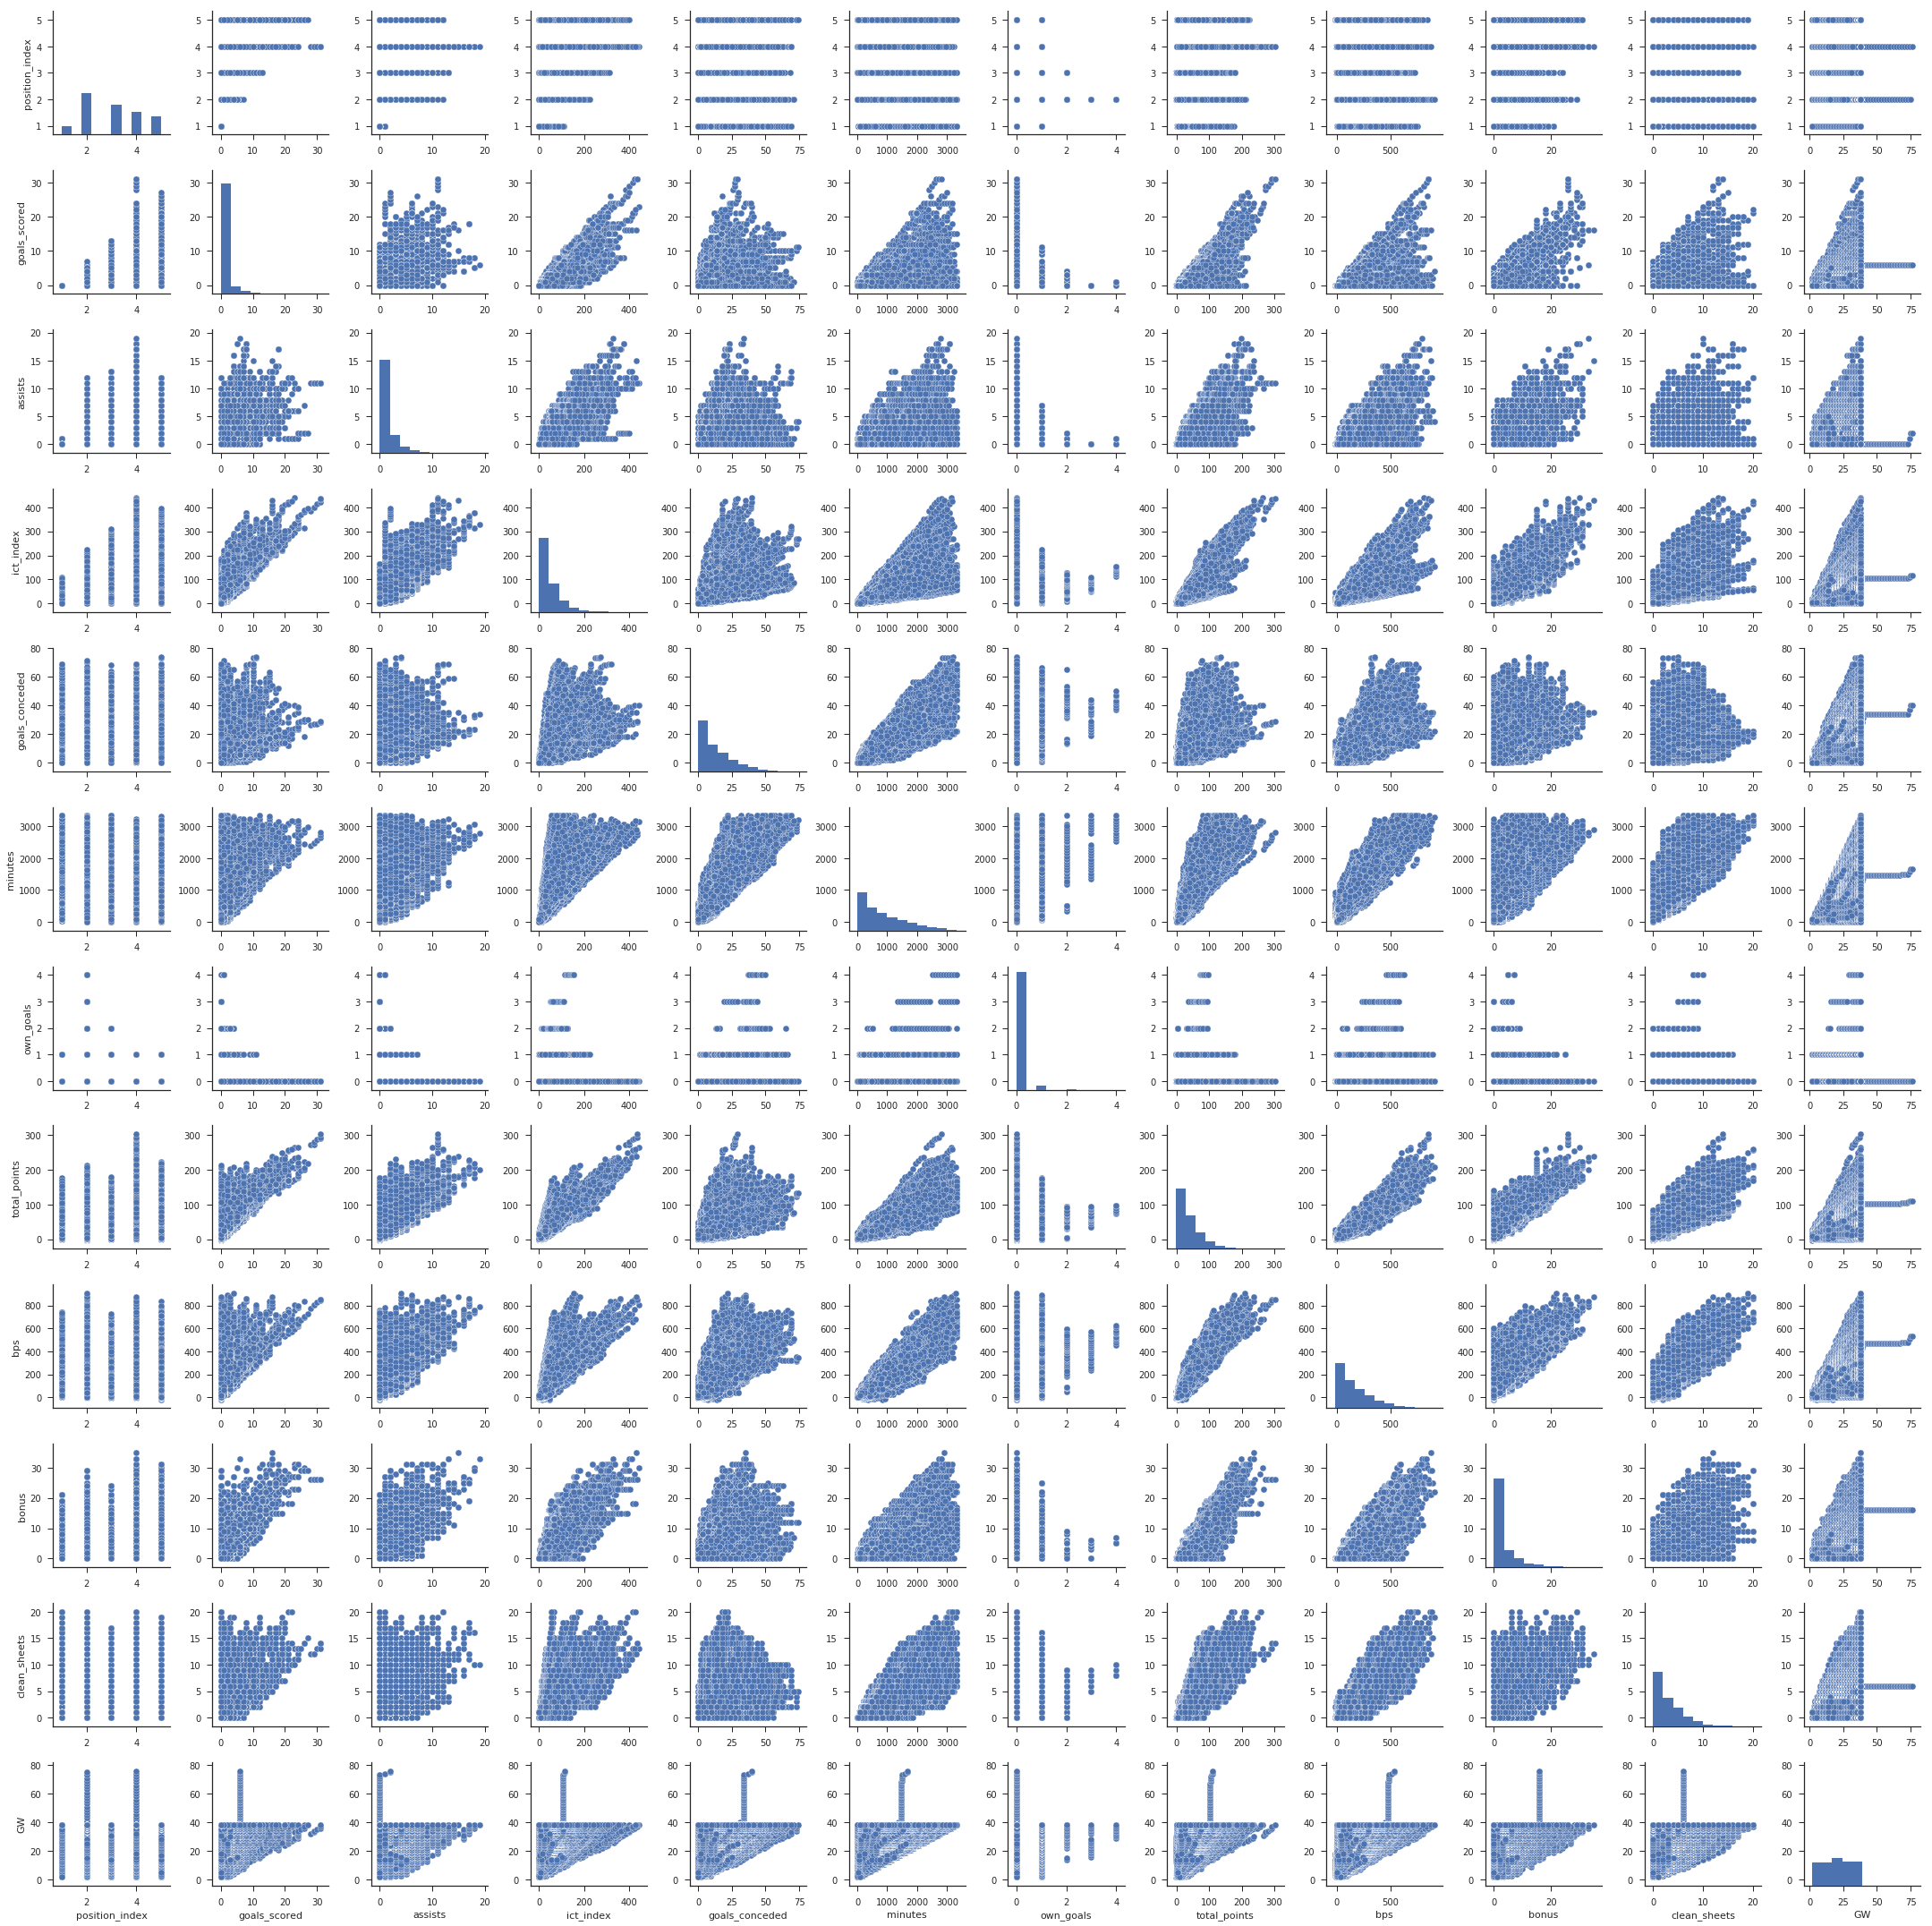

In [57]:
sns.pairplot(scom.drop('fpl_to_game', axis = 1));

In [58]:
scom_x, scom_y, scom_xm, scom_xtrain, scom_xtest, scom_ytrain, scom_ytest, scom_xtrain_new, scom_xtest_new = split_data(scom,10)

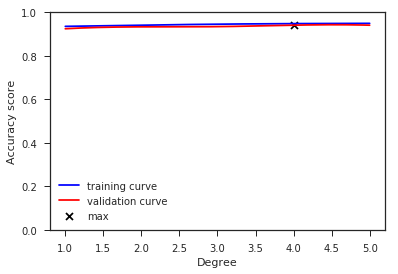

In [59]:
val_curve(model, scom_xm, scom_y)

In [60]:
model_s = make_pipeline(PolynomialFeatures(best_degree(model, scom_xm, scom_y)), LinearRegression())

In [61]:
scom_pred = model_s.fit(scom_xtrain_new, scom_ytrain).predict(scom_xtest_new)

In [62]:
r2_score(scom_pred, scom_ytest)

0.9456944358171373

In [63]:
score_com = cross_val_score(model_s, scom_xm, scom_y, cv = 5)
score_com

array([ 0.91507325,  0.94955343,  0.93581957,  0.95411657,  0.94108034])

In [64]:
score_com.mean()

0.93912863225281418

In [65]:
new_output(scom_xtest, scom_ytest, scom_pred)

player_name  ict_index  bps  position_index  minutes  bonus  \
0        Arouna Koné        4.6    9               5       46      0   
1       Alfie Mawson        1.9   30               2       90      1   
2  Kepa Arrizabalaga       48.0  522               1     2520      4   
3        Troy Deeney        7.8   15               5      270      0   
4          Eric Dier       27.6  134               3      757      0   

   total_points  fpl_to_game  pred_points  fpl_to_game pred  
0             4     7.826087     3.856797          7.545907  
1             6     6.000000     6.108742          6.108742  
2           116     4.142857   119.360314          4.262868  
3            13     4.333333     5.758383          1.919461  
4            26     3.091149    27.019756          3.212388